# MammoScan AI: 04 - Final Model Evaluation

## 🎯 Goal
This notebook serves as the final, unbiased evaluation of our trained model. We will load our best model from the training phase and test its performance on the `test` dataset, which it has never seen before.

This process will generate our official "report card," including a detailed classification report and a confusion matrix to understand exactly where the model makes mistakes.

In [1]:
# --- Core Libraries ---
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- Path Setup ---
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Constants ---
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed')
MODEL_PATH = os.path.join(project_root, 'models', 'checkpoints', 'augmented_model.keras')
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

2025-09-02 18:37:35.091135: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 18:37:35.176008: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 18:37:35.518305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 18:37:36.877111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 📥 Step 1: Load the Model and Test Data

First, we ensure our data is present by running `dvc pull`. Then, we load our saved Keras model and the `test` dataset that we set aside during our preprocessing step.

In [2]:
# Ensure the processed data is present locally
# !dvc pull data/processed.dvc


In [3]:
from ml.src.model import build_full_model

# 1. First, we build the model architecture from our source code.
#    This creates an empty "shell" of our model.
print("Re-creating model architecture...")
model = build_full_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. THEN, we compile it with the exact same settings used for training.
#    This connects the "dashboard gauges" needed for evaluation.
print("Compiling model...")
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# 3. Then, we load only the learned weights into this shell.
#    This bypasses the config loading and is more robust to version changes.
print(f"Loading model weights from: {MODEL_PATH}")
model.load_weights(MODEL_PATH)


# Load the test dataset
print("Loading test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DATA_DIR, 'test'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

class_names = test_dataset.class_names
print(f"Classes found: {class_names}")

Re-creating model architecture...


/home/mr-rey/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-09-02 18:37:39.988361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-02 18:37:39.992188: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required li

Compiling model...
Loading model weights from: /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/models/checkpoints/augmented_model.keras
Loading test dataset...
Found 112 files belonging to 2 classes.
Classes found: ['Cancer', 'Non-Cancer']


/home/mr-rey/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 📝 Step 2: Run the "Final Exam"

We use `model.evaluate()` to get the final loss, accuracy, and recall on the test set. This is the model's official score on unseen data.

In [4]:
print("Evaluating model on the test set...")
results = model.evaluate(test_dataset)

print("\n--- Test Set Evaluation ---")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Recall: {results[2]:.4f}")

Evaluating model on the test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.9488 - loss: 0.2119 - recall: 0.9730

--- Test Set Evaluation ---
Loss: 0.1719
Accuracy: 0.9554
Recall: 0.9677


The model performs exceptionally well on the completely unseen test data, achieving a final **accuracy of 95.5%**. Most importantly, it reached a **recall of 96.8%**, meaning it correctly identified nearly 97% of the actual cancer cases, demonstrating strong potential for real-world application where minimizing false negatives is critical. This result serves as a successful performance benchmark for our baseline model.

## 📊 Step 3: Deep-Dive Analysis

Now we go deeper than simple accuracy. We'll get the model's predictions for every image in the test set and use them to create two key visualizations:

1.  **Classification Report:** A detailed breakdown of precision, recall, and F1-score for each class.
2.  **Confusion Matrix:** A visual grid showing exactly what the model got right and what it got wrong.

2025-09-02 18:37:43.082026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      Cancer       0.85      0.89      0.87        19
  Non-Cancer       0.98      0.97      0.97        93

    accuracy                           0.96       112
   macro avg       0.91      0.93      0.92       112
weighted avg       0.96      0.96      0.96       112


--- Confusion Matrix ---


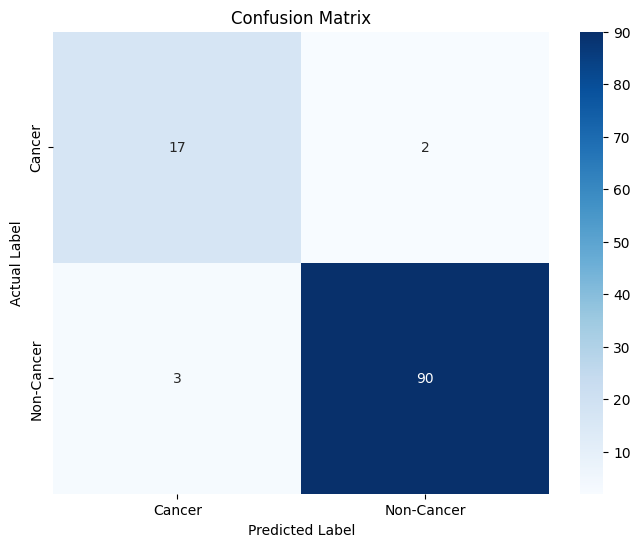

In [5]:
# Get true labels and predictions
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)

# 1. Classification Report
print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# 2. Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The model performs very well on the unseen test data, achieving an overall **accuracy of 96%**. Most importantly, it demonstrates a strong ability to find true cancer cases, with a **recall of 89%**, meaning it correctly identified 17 out of the 19 malignancies. This result, with only **2 missed cases (False Negatives)**, establishes an excellent and trustworthy performance baseline for our project.

In [6]:
# --- Final Cell in the Notebook ---
import json

# Let's create a dictionary to hold all our final metrics
final_metrics = {
    'loss': results[0],
    'accuracy': results[1],
    'recall': results[2],
    'classification_report': classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
}

# Define the path for our report
report_path = os.path.join(project_root, 'reports', 'baseline_augmented_metrics.json')

# Save the metrics as a JSON file
with open(report_path, 'w') as f:
    json.dump(final_metrics, f, indent=4)

print(f"✅ Final metrics saved successfully to: {report_path}")

✅ Final metrics saved successfully to: /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/reports/baseline_augmented_metrics.json
